<a href="https://colab.research.google.com/github/RXHem/Bottyforfun/blob/main/Qtrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teaching a robot to 'buy low, sell high'

In AI we are witnessing a variation of the [Argumentum ad lunam](https://rationalwiki.org/wiki/Argumentum_ad_lunam):
> *"If we can put a man on the moon,  we must be able to X"*.
(informal fallacies or false analogies)




But now it uses Alpha Go or Watson examples:

> *If  "AlphaGo Zero: Google DeepMind supercomputer [can learn] 3,000 years of human knowledge in 40 days" [[link](https://www.telegraph.co.uk/science/2017/10/18/alphago-zero-google-deepmind-supercomputer-learns-3000-years/)]*

>  *Then  "AI Trading Systems Will Shake Up Wall Street"  [[link](http://www.itprotoday.com/machine-learning/how-ai-trading-systems-will-shake-wall-street)] *

In [AI in Finance: Cutting Through the Hype ](https://medium.com/@gjlr2000/ai-in-finance-cutting-through-the-hype-with-case-studies-f361518b00d4) I explained several examples of the application of AI in Finance, but I left out the 'holy grail': developing an artificial system that finds profitable strategies. Notice that this is different from *predicting* asset prices; what we really want is the trader to *act* on the information and maximize wealth.

Luckily, Gordon Ritter from NYU built such a system (as published by Newsweek in [CAN MACHINE LEARNING BE APPLIED TO TRADING?](http://www.newsweek.com/business-technology-trading-684303)) which is very nicely explained in his academic paper:
> **[Machine Learning for Trading](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3015609)**

Following my practice of using replicable research for case studies in AI, I replicated Ritter's paper in this notebook. As before, I will try to reduce the jargon ('Q-learning' 'MDP' ?) and try to highlight the intuition behind it.

**Spoilers**: Yes, the system can *learn* a profitable strategy from scratch *if* you have millions of examples *and* the current price only depends on the previous price. *But* there are ways (in research stage) to improve it.  

**Note**: This python code was developed as a didactic tool, and will be painfully slow for commercial applications - Ritter wrote it in Java and it "completes one million iterations in seconds". My goal was to use Google Colaboratory in a single file to make sure the result is replicable by anyone. 

The following section sets the parameters as defined by Ritter:



(I add the usual python libraries, then I will create the list of possible actions,  portfolios and prices.)


In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Initialize: 
# True -- will reset Q_space
# False -- will try to use Q_space in memory (or reset if there is none)
Initialize = True

#Parameters from Ritter's paper
H = 5
Param = {
        'epsilon' : 0.1,
        'alpha' : 0.001,
        'gamma' : 0.999,
        'lambda'  : np.log(2)/H,
        'kappa'  : 0.0001,
        'sigma'  : 0.1,
        'P_min'  : 0.1,
        'P_max'  : 100,
        'P_e'  : 50.0,
        'LotSize'  : 100,
        'K'  : 5,
        'M'  : 10,
        'TickSize'  : 0.1,
        'N_train' : np.power(10,5)
        
}
# N_train is 10^7 (10mn) for Ritter - 
# I use 10^5 iterated 10 times so a total of 10^6 (1mn)
# (which is better to show the improvement on the strategy)


Practitioners will see a few constants that mean something:
> P_e: refers to the 'arbitrage' price, or the price around which the price simulator will oscillate. So 'buy low' should happen when the Price is below P_e, and 'sell high' when the price is above P_e

>P_min, P_max: are the boundaries of the price (so it can only go from 0.1 to 100). This is a first **red flag** to a practitioner which is used to prices being able to jump. 

>LotSize: Minimum size of (equities/contracts) that can we trade.

>TickSize: is the minimum price movement of a trading instrument.

>K: refers to the actions that each trade can take: from -K to +K lot sizes
 
>M: is the multiple of lot Sizes than the total portfolio can hold

>$\gamma$ is the only greek letter that could refer to a financial term: the one period discount factor of future rewards (and could be linked to the risk free rate). 

The rest of  the greek letters ($\alpha$, $\epsilon$,  $\lambda$, $\kappa$, $\sigma$) are the beloved symbols used by academics to refer to constants used within their models. I will explain them further when we see them in the code

>$\sigma$ and $\lambda$ are parameters used to determine the price bands around the 'arbitrage' level P_2 and the speed of mean reversion

>$\alpha$, $\epsilon$, and $\kappa$ are parameters used to tune the Q-learning.


In [ ]:
#python requires the additional +1 to get the full range {-K, -K+1, ..., K}

ParamSpace = { 
    'A_space' : np.arange(-Param['K'] ,Param['K']+1)*Param['LotSize'],
    'H_space' : np.arange(-Param['M'],Param['M']+1)*Param['LotSize'],
    'P_space' : np.arange(1,Param['P_max']/Param['TickSize']+1)*Param['TickSize'],

     }



Lets review the list of possible actions. It should go from -K*LotSize = -500 to +500:

In [ ]:
print (ParamSpace['A_space'])

[-500 -400 -300 -200 -100    0  100  200  300  400  500]


And the H space is the set of possible portfolios, going from -M * LotSize = -1000 to +1000

Why H space ? Well, Ritter called it $\mathcal{H}$-space as Holding-space; I guess to differentiate from the P-space which is used for prices. Oh, and space is a legacy from the control theory used to develop the learning algorithms ([State-space](https://en.wikipedia.org/wiki/State-space_representation)).

In [ ]:
print (ParamSpace['H_space'])


[-1000  -900  -800  -700  -600  -500  -400  -300  -200  -100     0   100
   200   300   400   500   600   700   800   900  1000]


I will not print the Price-space, but imagine it going from [0.1 to 100] in 0.1 steps.

The spaces set up above are very important for the code, and below I define functions that will make sure whenever a price (or holding) is generated. That way I avoid having to deal with prices that fall within ticks. **Note** this part can be optimized if you are a hard-core coder.

In [ ]:
#to make sure we do not get Prices and Holdings outside of
#the valid state 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def Price(d):
    return find_nearest(ParamSpace['P_space'], d)

def Holding(d):
    return find_nearest(ParamSpace['H_space'], d)    

## Price Simulation
This is a very important part. Ritter chose 

> *"a tradable security with a strictly positive price process $p_t > 0$.  ... $p_t$ tends to revert to its long-run equilibrium level pe with mean-reversion
rate $\lambda$, [volatility $\sigma$] and is a standard discretization of the Ornstein-Uhlenbeck process."*

Please refer to the paper for the exact details, but now you can see where the $\lambda$ and $\sigma$ parameters are needed - they are not used to 'learn' but to simulate the price action.

Let's see an example:


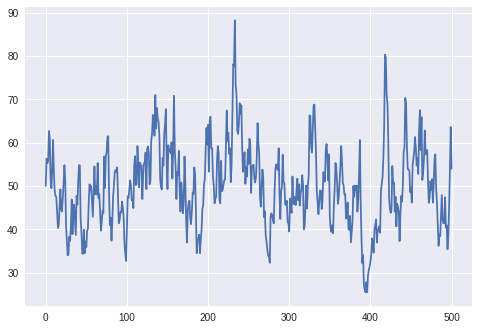

In [ ]:
def PriceSampler(sampleSize):
    eps_t = np.random.randn(sampleSize)
    pe = Param['P_e']
    sigma = Param['sigma']
    lambda_ = Param['lambda']
    p = Price(pe)
    
    prices = [p]
    for i in range(0,sampleSize):
        y = np.log(p / pe)
        y = y + sigma * eps_t[i] - lambda_ * y
        pnew = pe * np.exp(y)
        pnew = np.min([pnew, Param['P_max']])
        # discretizing to make sure it appear in P_space
        prices.append(Price(pnew))
        # this one seems missing !
        p = pnew
    return prices
  
sample = PriceSampler(500)
plt.plot(sample)

Mmm....

You can see that the price action kind of oscillates quite rapidly around 50 (the P_e) we selected

Is that a realistic assumption ? That is another discussion, and I have written extensively about Mean Reverting trading in
[Trading Mean Reversion: the full series.](https://www.linkedin.com/pulse/trading-mean-reversion-full-series-gerardo-lemus/) 

**Important**:  the PriceSampler **can** be changed to another Price dynamic, **as long** as the current Price only depends on the previous Price so that we can fit the action into a Markov Decision Process (MDP - read Ritter's piece). 

For example, in Ritter's code the Price is made to be always positive, but in the examples I mention in my blogs that is not the case (the signals can be also negative). I could change the PriceSampler to reflect this case, as I know the dynamics only depend in the previous prices in both cases.

**Note** check both my blog [MeanReversion:definitions](https://medium.com/@gjlr2000/mean-reversion-in-finance-definitions-45242f19526f) and Ritter's paper to see the difference in the mean reverting formula.

**Note 2** Instead of using Prices we can use other variables (like returns) that only depend on the previous value - but that requires re-defining the architecture. 


## Building the Cheatsheet
### ("How many times have I told you too ..." or Q-learning)

[Q-learning](https://en.wikipedia.org/wiki/Q-learning) is another term borrowed from academia and control -theory, but we can see it as Cheatsheet writing.

Once the Cheatsheet is done, all the robot has to do is to follow its instructions to trade. In classical Algorithmic Trading the rules are set up by a coder; in Q-learning the robot will first 'train' in a safe environment (no money needed) - it will perform actions and then will write the reward back in the Cheatsheet (just like an exasperated parent educating a child, to be repeated thousands of times)



So lets create the Cheatsheet (or Q-space):

In [ ]:

#State_space = pd.DataFrame(index = ParamSpace['P_space'], columns = ParamSpace['H_space'])
iterables = [ ParamSpace['P_space'], ParamSpace['H_space'] ]
State_space = pd.MultiIndex.from_product(iterables)


try:
    Q_space
    if Initialize:
      Q_space = pd.DataFrame(index = State_space, columns = ParamSpace['A_space']).fillna(0)
  
except:
    Q_space = pd.DataFrame(index = State_space, columns = ParamSpace['A_space']).fillna(0)


All the combinations of Prices and Holdings are called the 'State-Space', and Q-space is extended by adding another dimension (actions).

Below you can see a glimpse of it.

You will notice that the rows represent all possible combinations of Prices and Portfolios, and the columns are the possible actions. All is started with zeros, and eventually it will be filled with positive or negative rewards during training.

This Cheatsheet has 21k rows and 11 columns, or 231k cells that need to be filled. Not all of them will be visited during training (as the Price dynamics might not end up in some cells), but now you can start to see why you need millions of training samples (as you cannot rely in a single observation per visit, you need to average a few). 



**Note**: the definition of State-Space has to be done very carefully and is one of the critical parts of the robot. In this case Prices were directly used as part of the state, but in other dynamics (like a raising stock market) that is not possible - you have to use returns instead (make the process [stationary](https://en.wikipedia.org/wiki/Stationary_process))

In [ ]:
print (Q_space)


             -500  -400  -300  -200  -100   0     100   200   300   400   500
0.1   -1000     0     0     0     0     0     0     0     0     0     0     0
      -900      0     0     0     0     0     0     0     0     0     0     0
      -800      0     0     0     0     0     0     0     0     0     0     0
      -700      0     0     0     0     0     0     0     0     0     0     0
      -600      0     0     0     0     0     0     0     0     0     0     0
      -500      0     0     0     0     0     0     0     0     0     0     0
      -400      0     0     0     0     0     0     0     0     0     0     0
      -300      0     0     0     0     0     0     0     0     0     0     0
      -200      0     0     0     0     0     0     0     0     0     0     0
      -100      0     0     0     0     0     0     0     0     0     0     0
       0        0     0     0     0     0     0     0     0     0     0     0
       100      0     0     0     0     0     0     0     0     

Later on I'll explain how to use the Cheatsheet - but **note** that as it stands the default action will be the first one (sell -500); instead, we might want to fill the Action = 0 column with a small positive number to make sure our robot does not bet the house after training.

Above I mentioned that we need to fill the Q-space by applying rewards each time we train. 

In case someone mentions '[Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation)', keep in mind that this is the method used to fill the Q-space and that it comes from a methodology called 'dynamic programming'.

**Note** Defining a reward that fits the Bellman equation is another critical part. It turns out the Bellman equation requires a 'Markov Decision Process' because the reward is computed recursively but only if the underlyng state process is stationary.

### Definition of Reward
As a practitioner, I liked that Ritter did not shirk away from transaction costs and risk aversion, and developed a reward function that includes them.

Lets start with the costs:
> SpreadCost: depends on how many lots you trade,

> ImpactCost: includes a simple model of the impact on the market as a function of the size

**Note** Most important; here is where you can add more realistic cost (Ritter mentions financing as example). And finally we are seeing advantages of this method over theoretically-derived strategies: many of those require many assumptions that become unrealistic, but using a machine learning approach you can add them to the simulation.


In [ ]:
def SpreadCost(d_n):
    return Param['TickSize'] * np.abs(d_n)

def ImpactCost(d_n):
    return (d_n*d_n)*Param['TickSize']/Param['LotSize']

def TotalCost(d_n):
    return SpreadCost(d_n) + ImpactCost(d_n)

As for the reward, Ritter did a very good job of defining it in a form that is intended to maximize the resulting Sharpe Ratio. If you were only maximizing PnL the optimal policy might simply be greedily buying all it can whenever the Price is low.

Here is where you you will $\kappa$ being used: it penalizes the PnL is the variance is too high. Read the paper for more details. 

**Note**: The fine print when applying this specific reward function specifies that the asset returns should be "mean-variance equivalent", which roughly means that the statistics of the resulting simulation only have two parameters. If you believe you need another one (which is the case when people think of adding 'black swans' scenarios happening randomly) then the theory stops working - however, your two parameters can be part of a distribution that uses 'fat tails'.

In [ ]:


'''
def PnL(prePrice, nextPrice, totalCost, n):
    return n * (nextPrice - prePrice) - totalCost;

def Reward(prePrice, nextPrice, totalCost, n):
    pnl = PnL(prePrice, nextPrice, totalCost, n)
    return pnl - 0.5 * Param['kappa'] * (pnl * pnl)
'''

def ResultReward(currState, nextState):
    currPrice = currState[0]
    nextPrice = nextState[0]
    currHolding = currState[1]
    nextHolding = nextState[1]
    dn = nextHolding - currHolding
    cost = TotalCost(dn)
    pricedif = nextPrice - currPrice
    pnl = nextHolding * pricedif - cost
    reward = pnl -0.5 * Param['kappa'] * (pnl * pnl)
    result = {
            'pnl': pnl,
            'cost': cost,
            'reward' : reward,
            'dn' : dn
            }
    return result


This are the functions that will aid us to fill the Cheatsheet (Q-space).

You will notice another one of the parameters we defined above ($\epsilon$). This one is used to make sure during training that the robot chooses actions that it has not tried before.

In [ ]:

def getQvalue(state):
    price = state[0]
    holding = state[1]
    return Q_space.loc[(price, holding),]

def argmaxQ(state):
    return getQvalue(state).idxmax()

def getMaxQ(state):
    return getQvalue(state).max()


def chooseAction(state):
    random_action = np.random.rand()
    if (random_action < Param['epsilon']):
        A_space = ParamSpace['A_space'] 
        dn = A_space[np.random.randint(len(A_space))]
    else:
        dn = argmaxQ(state)
    return dn

And finally we reach the Q-learning !

This part is bases on the 'Bellman equation' I mentioned above:

Imagine we start at state (currState: Price = 50, Holding = 0), and we know the next Price is 49.8:



1.   Look at the Cheatsheet, row (50, 0). On that row, we will pick either the action with the highest value or a random action (as defined in the chooseAction function).
2.   With that action (lets say it was to buy 100 lots) we update the state (nextState: Price = 49.8, Holding = 100), and the reward is negative ! (we lost money - bad robot)
3. We update the Cheatsheet on (currState: P= 50, H=0) with a negative number - it is not a good idea to buy if the price is close to 50. Here is where we introduce $\alpha$ (the rate of learning)




In [ ]:
def qLearning():
    pricePath = PriceSampler(Param['N_train'])
#    plt.plot(pricePath)
    # initialize holding at first holding possible
    currHolding = Holding(0)
    
    for i in range(0, Param['N_train']-1):
        # indexing
        currPrice = pricePath[i]
        currState = (currPrice, currHolding)
        
        # choose action
        shares_traded = chooseAction(currState)
        
        nextHolding = Holding(currHolding + shares_traded)
        
        nextPrice = pricePath[i+1]
        nextState = (nextPrice, nextHolding)
        
        result = ResultReward(currState, nextState)
        q_sa = Q_space.loc[currState, shares_traded]
        increment = Param['alpha'] * ( result['reward'] + Param['gamma'] * getMaxQ(nextState) - q_sa)
        Q_space.loc[currState, shares_traded] = q_sa + increment
        
        currHolding = nextHolding
        
        #if ( i% np.power(10,5) == 0):
        #    print(i)            
        #Q_space.to_pickle('q_space')
    return i


Let's try it !

First, lets define a way to create a Price sequence which is outside the training sample:

In [ ]:
            
 
def OutOfSample(nsteps):
    pricePath = PriceSampler(nsteps+1)
    currHolding = Holding(0)
    pnl = []
    
    for i in range(0, nsteps):
        
        currPrice = pricePath[i]
        currState = (currPrice, currHolding)
        shares_traded = chooseAction(currState)
        
        nextHolding = Holding(currHolding + shares_traded)
        
        nextPrice = pricePath[i+1]
        nextState = (nextPrice, nextHolding)
        
        result = ResultReward(currState, nextState)
        pnl.append(result['pnl'])
        
        currHolding = nextHolding
        
    return pd.DataFrame(pnl)
    
 

Off to the races:

I train the robot 10 times, and hopefully you will see how the accumulated PnL improves after each iteration. The first time should see a very poor performance (around -200k after 5k samples), which should improve by the last one (+600k)

And if you keep it running around 10mn times, you should replicate Ritter's Figure 4.1 with almost straight line raising to 2.5mn PnL.

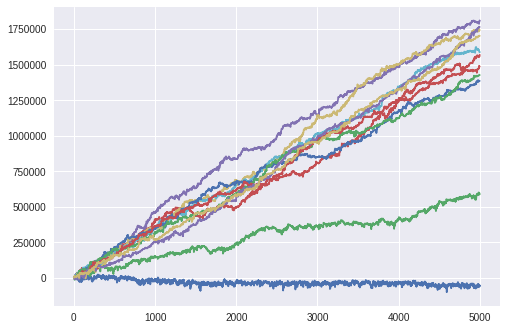

In [ ]:
   
pnl = OutOfSample(5000)
pnl_sum = pnl.cumsum()
plt.plot(pnl_sum)

for i in range(0,10):
  itr = qLearning()
  pnl = OutOfSample(5000)
  pnl_sum = pnl.cumsum()
  plt.plot(pnl_sum)


    
    

In [ ]:
Q_space.to_pickle('Q_space_ritter')
from google.colab import files
files.download('Q_space_ritter')


## Analyzing the Q-trader

Among many reasons, I wanted to replicate the code in Python (instead of a faster language) because I wanted to 'see through' the results.

I wanted to see the 'optimal policy' by myself. Doing the coding with Pandas allows us to quickly see the 'buy low, sell high' policy.

If I aggregate the Q-space by price and then show the action that has the maximum value - I get the following picture:


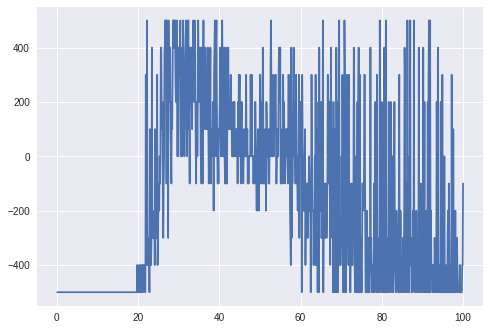

In [ ]:
Q_price = Q_space.groupby(level = [0]).sum()
Q_action = Q_price.idxmax(axis =1)
plt.plot(Q_action)

Unsurprisingly, the optimal policy has a 'buy' bias for prices between 30 and 50, and 'sell' between 50 and 100.

Still - it is not very smooth. As the Q-space is large, some states are not visited very often and the first memory (lets say a random profit) remains. Prices below to 20 are also ignored and set up to the default (sell -500).

For the full picture, see below the full colour action cheatsheet per state. 

You can notice that some states (usually prices below 20) remain unvisited. Also, the action will depend not only on the price but on the current holding.


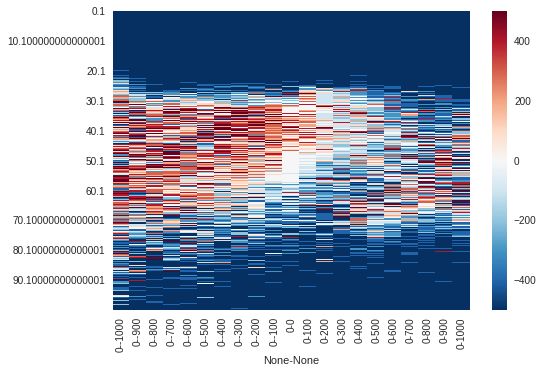

In [ ]:
Q_full_action = (pd.DataFrame(Q_space.idxmax(axis =1))).unstack()

import seaborn as sns

ax = sns.heatmap(Q_full_action, yticklabels=100)
plt.show()

## Still early, but setting up the foundations:

Ritter's paper shows that you can train a robot from scratch under a very limited set of conditions:


*   The asset price need to be memoryless (do not depend on the paste beyond the current price)
* The reward is tailored to maximize Sharpe Ratio *if* the simulations replicate random numbers generated with only two parameters (notice that even if we have three parameters, P_e, $\lambda$ and $\sigma$, they will be combined into 2 in the output of the simulation). The reward uses a variable $\kappa$ which regulates the risk aversion.
* There are many parameters ($\alpha$, $\epsilon$) which seem to be 'magically' defined
*   And most importantly: you should be able to generate huge amount of simulations.

But Ritter did not plan to create a full-fledged Robo-Buffet, instead **he developed the blueprint** and each one of the points above can be improved. For instance:


### Changing the reward
The reward function can be twisted to favour gains over losses (one of the big bugbears of traders) by changing the line


```
reward = pnl -0.5 * Param['kappa'] * (pnl * pnl)
```
to 


```
loss = np.min(0,pnl)
reward = pnl -0.5 * Param['kappa'] * ( loss * loss)
```

so that Robo-Buffet is not penalized when making large gains. 

While it makes sense to change the reward function, we loose sense of what are we really maximizing, and we have to be careful.

### Changing the architecture:
The reason why only memoryless prices can be used for training is due to the choice of state architecture. There are many tricks to improve this -- for instance, in gaming:


> *"DQN is trained using an input consisting of the last four game screens"*
> [Deep Q-Learning with Recurrent Neural Networks](http://cs229.stanford.edu/proj2016/report/ChenYingLaird-DeepQLearningWithRecurrentNeuralNetwords-report.pdf)

We could copy this trick by adding the last N prices to the state, something like:


```
currState = (currPrice, prev_1_Price, prev_2_Price, currHolding)
```
If we do that, the State Space grows dramatically, and using deep learning neural networks *instead* of the big Q-space cheatsheet makes sense (read the above paper)

Additionally, instead of prices we can use 'hidden states' that output Prices (to make sure the end up states following the memoryless property that the theory requires)

### But we need data, data, data.
Having a model of the financial world to develop a model-less robo trader seems like an oxymoron: if you have the model you might as well use it to compute directly the dynamic programming equations without relying on 'Q-learning'

Still, with cheap computer power it might be faster just to develop the model and blast the solution away. And in some domains (High Frequency Trading) the data might be available !









